<h2>PART 1. Data Pre-processing</h2>

<h3>Step #0. Fire the system</h3>

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

<h3>Step #1. Read data</h3>

In [3]:
# Importing Training Set
dataset_train = pd.read_csv('GOOG.csv')

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (4006, 7)
All timestamps == 4006
Featured selected: ['Open', 'High', 'Low', 'Close', 'Adj Close']


The dataset contains 4,006 rows of Google stock market data, with 7 columns, including the date, open, high, low, close, and adjusted close prices. The selected features for analysis are 'Open', 'High', 'Low', 'Close', and 'Adj Close'.

<h3>Step #2. Stationary checking and transformation</h3>
<p>
Determine if the "open" (target variable) is stationary.
</p>

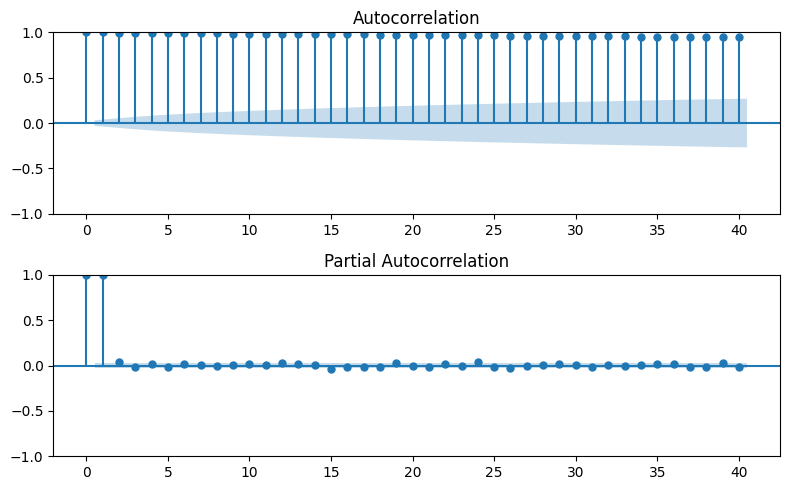

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define a function to draw ACF and PACF to test if the data is stationary.
def plot_acf_pacf(series, lags=5):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
    plot_acf(series, lags=lags, ax=ax1)
    plot_pacf(series, lags=lags, ax=ax2)
    plt.tight_layout()
    plt.show()

# Analyze the 'Open' column
open_column = dataset_train['Open']
plot_acf_pacf(open_column, lags=40)


The ACF plot shows a slow decay and doesn't quickly approach zero, indicating that the 'Open' column is likely __non-stationary__. The PACF plot shows significant spikes that cut off after lag 2, suggesting an AR(2) process might be appropriate if the series were made stationary.
<br><br>
Why is stationery important for Time-series data?
- Many ML models (LSTM included) assume stationary to predict patterns.
- Non-stationary data can exhibit trends or change variance over time, making it difficult to predict without transformation


Now we need to transfer all variables to the stationary dataset by using __smoothing-average__ method.

In [5]:
from scipy.signal import convolve

# Define a function that smooths fetures to make data stationary
def smooth_and_difference_dataframe(df, window_size=5):
    """
    Apply moving average smoothing and then differentiate the data to make it stationary.
    Pads the beginning to maintain the original number of rows.
    """
    transformed_data = pd.DataFrame(index=df.index, columns=df.columns)
    
    for column in df.columns:
        series = df[column].values
        
        # Pad the beginning of the series with the first value
        padded_series = np.pad(series, (window_size - 1, 0), mode='edge')
        
        # Apply moving average smoothing
        weights = np.ones(window_size) / window_size
        smoothed = convolve(padded_series, weights, mode='valid')
        
        # Difference the smoothed series
        differenced = np.diff(smoothed, prepend=smoothed[0])
        
        transformed_data[column] = differenced
    
    return transformed_data

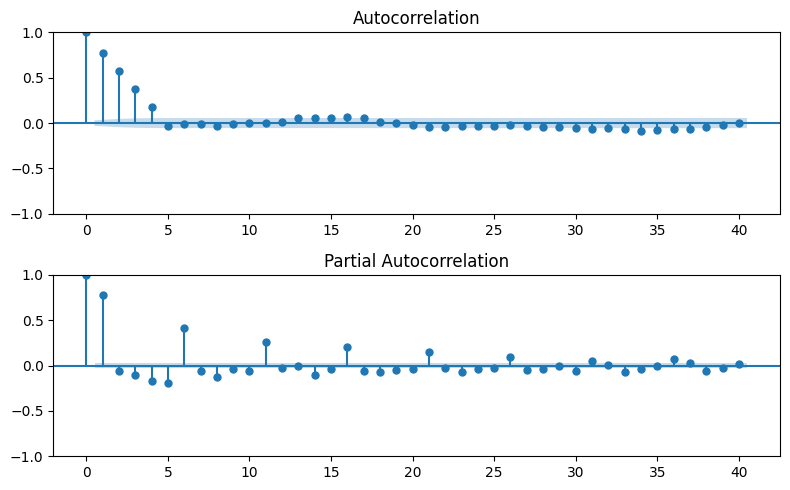

In [6]:
# Apply stationary transformation to all features
dataset_train_stationary= smooth_and_difference_dataframe(dataset_train.iloc[:,1:], window_size=5)

# Set the Datetime column to as index of the stationary dataframe
dataset_train_stationary = dataset_train_stationary.set_index(dataset_train['Date'])
dataset_train_stationary.index = pd.to_datetime(dataset_train_stationary.index)

# Visualize ACF and PACF to determine stationary for "Open" (target variable)
open_column = dataset_train_stationary['Open']
plot_acf_pacf(open_column, lags=40)

- Now we an see that ACF plot decay so we can state the the feature is stationary.
- The PACF shows spikes every 4 data points that decay over time, so it suggests a seasonal pattern with a period of 4 in your time series data.

<h3>Step #3. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [10]:
dataset_train_stationary = dataset_train_stationary[cols].astype(str)
for col in cols:
    dataset_train_stationary[col] = dataset_train_stationary[col].str.replace(',', '', regex=False)

dataset_train_stationary = dataset_train_stationary.astype(float)

# Using multiple features (predictors)
training_set_stationary = dataset_train_stationary.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set_stationary

Shape of training set == (4006, 5).


array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.1006232,  0.500125 ,  0.4523048,  0.794023 ,  0.794023 ],
       [ 1.0709862,  0.9384818,  1.3041114,  0.902616 ,  0.902616 ],
       ...,
       [ 5.7620118,  5.8899902,  2.473999 ,  3.528003 ,  3.528003 ],
       [-1.2899902, -0.806006 , -0.3549804,  1.402002 ,  1.402002 ],
       [ 3.0939942, -4.078003 ,  0.376001 , -5.2379882, -5.2379882]])

The dataset encompasses over 4,000 daily Google stock market prices, providing a comprehensive view of the company's historical performance. Prior to analysis, the feature data has undergone stationary transformation, addressing trends and seasonality to ensure consistent statistical properties over time. As a result of this transformation, the range across different features is not substantial, indicating relatively uniform scales.
<br><br>
However, applying normalization could still be beneficial for the following reasons:
- Model stability: Normalization can help ensure numerical stability in some machine learning algorithms, particularly those sensitive to the scale of input features.
- Computational efficiency: Normalized data can lead to faster convergence during model training, potentially reducing computational overhead.
- Feature comparison: Normalization allows for easier comparison between different features, which can be useful for interpreting model results.

In [77]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set_stationary)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set_stationary[:, 0:1])

array([[-0.08122574],
       [-0.05890987],
       [ 0.15629392],
       ...,
       [ 1.19665352],
       [-0.36731535],
       [ 0.60494971]])

Now, the values have been standardized for easier model training, but the results will also be scaled down to smaller values. Therefore, we need to apply an <code>inverse_transform</code> later when making the actual predictions to revert the values to their original scale.

<h3>Step #4. Pre-setup for LSTM</h3>
LSTMs (Long Short-Term Memory networks) are a type of Recurrent Neural Network (RNN) designed to model sequences and retain long-term dependencies. They are particularly effective for time-series data, where patterns from the past influence future values. Here's how they work and why specific parameters are required:

- n_past helps the model capture temporal dependencies and trends in the data. A longer past window might capture broader trends, while a shorter window might focus on recent patterns.
- n_future defines the target prediction horizon. The further into the future you want to predict, the more challenging it is, as uncertainties accumulate over time.

In [78]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_past = 90     # Number of past days we want to use to predict the future
n_future = 60   # Number of days we want to predict into the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train_stationary.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (3857, 90, 4).
y_train shape == (3857, 1).


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [79]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

Ussing sequential pacakges to desinge LSTM berual netowrk, adding 2 layers of LSTM, output layers and dropput rate.

In [80]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train_stationary.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

/Users/jinweisun/.asdf/installs/python/3.10.12/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<h3>Step #4. Start training</h3>

In [81]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.4458 
Epoch 1: val_loss improved from inf to 3.43454, saving model to weights.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.4434 - val_loss: 3.4345 - learning_rate: 0.0100
Epoch 2/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.3849
Epoch 2: val_loss did not improve from 3.43454
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.3898 - val_loss: 3.4404 - learning_rate: 0.0100
Epoch 3/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.4209 
Epoch 3: val_loss improved from 3.43454 to 3.41239, saving model to weights.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.4205 - val_loss: 3.4124 - learning_rate: 0.0100
Epoch 4/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.4006
Epoch 4: val_loss did not improve from 3.41239
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.4026 - val_loss: 3.4575 - learning_rate: 0.0100
Epoch 5/30
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.4367
Epoch 5: val

After 25 epochs of training, the model triggered early stopping as the validation loss did not decrease further beyond the defined threshold. The final loss achieved was 0.0882.

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>


<h2>PART 3. Make future predictions</h2>

In [82]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

<h3>Step #5. Make predictions for future dates</h3>

In [83]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 


In [84]:
predictions_train.shape

(3767, 1)

In [148]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Open']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(5)

,Open
2005-08-01,0.361357
2005-08-02,0.422998
2005-08-03,0.440391
2005-08-04,0.422551
2005-08-05,0.407201


<h3>Step #6. Visualize the Predictions</h3>

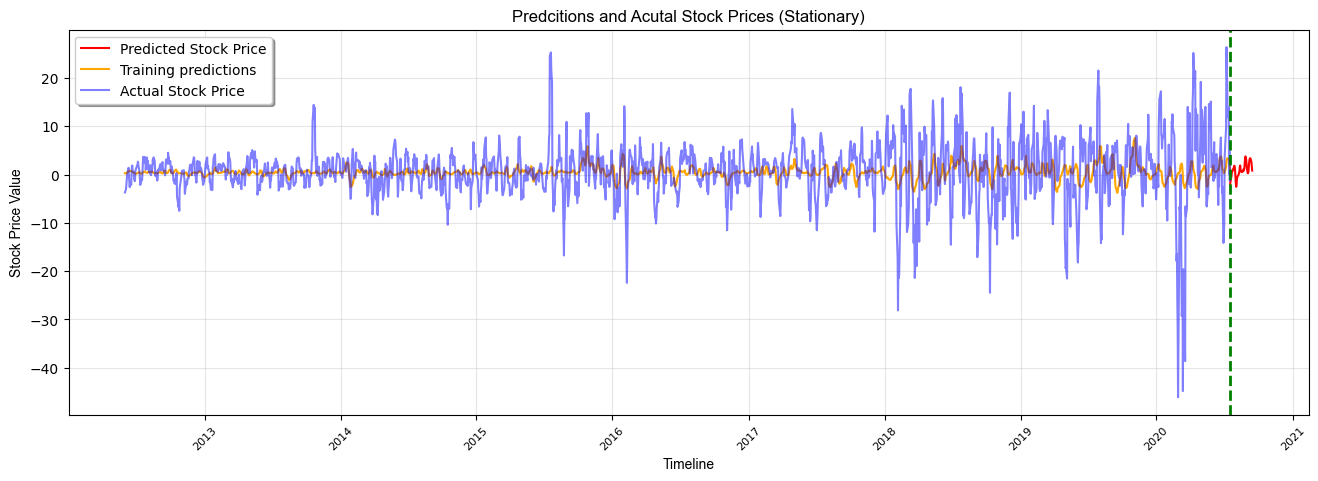

In [149]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2012-06-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train_stationary.loc[START_DATE_FOR_PLOTTING:].index, dataset_train_stationary.loc[START_DATE_FOR_PLOTTING:]['Open'], alpha=0.5 ,color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices (Stationary)', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

Now we can plot the data who has been transformed back to the apporixmately real price instea

In [153]:
def reverse_difference(transformed_df, initial_values):
    """
    Reverse the differencing transformation.
    
    :param transformed_df: DataFrame with differenced values
    :param initial_values: Series or DataFrame with initial values for each column
    :return: DataFrame with reversed differencing
    """
    reversed_data = pd.DataFrame(index=transformed_df.index, columns=transformed_df.columns)
    
    for column in transformed_df.columns:
        differenced = transformed_df[column].values
        initial_value = initial_values[column]
        
        # Undo differencing using cumulative sum
        undifferenced = np.cumsum(differenced) + initial_value
        
        reversed_data[column] = undifferenced
    
    return reversed_data

In [154]:
dataset_train_stationary_reversed = reverse_difference(dataset_train_stationary, dataset_train.iloc[0])
PREDICTION_TRAIN_reversed = reverse_difference(PREDICTION_TRAIN, dataset_train.iloc[0])
PREDICTIONS_FUTURE_reversed = reverse_difference(PREDICTIONS_FUTURE, PREDICTION_TRAIN_reversed.iloc[-1])

In [156]:
PREDICTION_TRAIN_reversed 

,Open
2005-08-01,50.174641
2005-08-02,50.597641
2005-08-03,51.038033
2005-08-04,51.460583
2005-08-05,51.867783
...,...
2020-07-13,1653.124512
2020-07-14,1656.037476
2020-07-15,1658.552612
2020-07-16,1660.290161


In [158]:
dataset_train_stationary_reversed.loc[START_DATE_FOR_PLOTTING:]['Open']

Date
2012-06-01     293.448084
2012-06-04     290.381574
2012-06-05     288.353180
2012-06-06     287.189539
2012-06-07     287.077960
                 ...     
2020-07-13    1509.383984
2020-07-14    1509.445996
2020-07-15    1515.208008
2020-07-16    1513.918018
2020-07-17    1517.012012
Name: Open, Length: 2045, dtype: float64

In [157]:
PREDICTION_TRAIN_reversed.loc[START_DATE_FOR_PLOTTING:]['Open']

2012-06-01     718.037048
2012-06-04     718.268005
2012-06-05     718.479126
2012-06-06     718.726257
2012-06-07     719.154419
                 ...     
2020-07-13    1653.124512
2020-07-14    1656.037476
2020-07-15    1658.552612
2020-07-16    1660.290161
2020-07-17    1661.107178
Name: Open, Length: 2045, dtype: float32

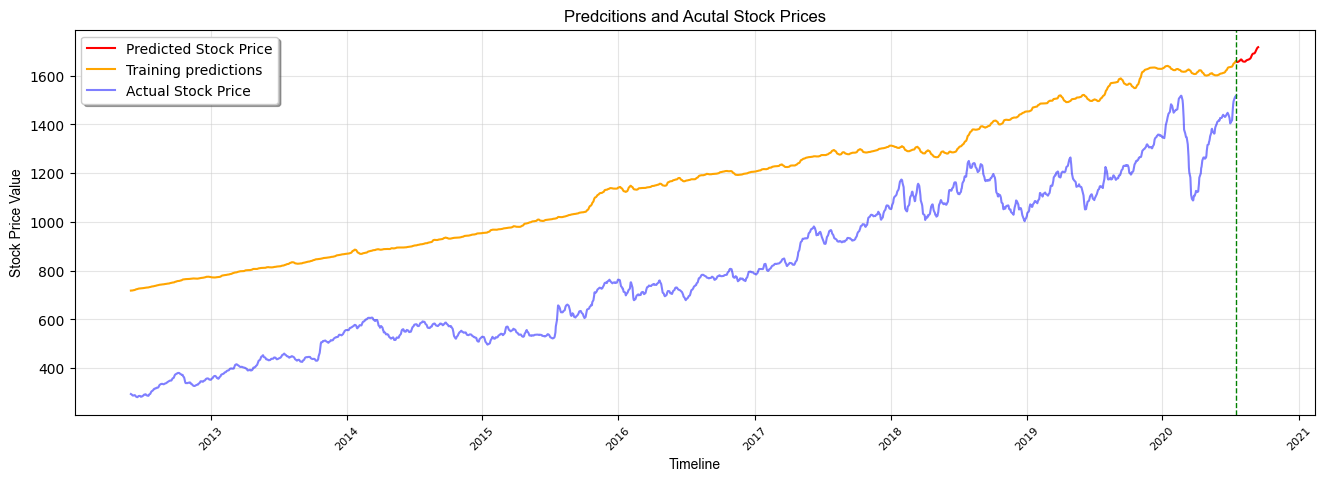

In [159]:
plt.plot(PREDICTIONS_FUTURE_reversed.index, PREDICTIONS_FUTURE_reversed['Open'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN_reversed.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN_reversed.loc[START_DATE_FOR_PLOTTING:]['Open'], color='orange', label='Training predictions')
plt.plot(dataset_train_stationary_reversed.loc[START_DATE_FOR_PLOTTING:].index, dataset_train_stationary_reversed.loc[START_DATE_FOR_PLOTTING:]['Open'], alpha=0.5 ,color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=1, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

## TO DO:
- Hyperparameter tuning: Use techniques like grid search or random search to optimize LSTM parameters.
- Model evaluation: Include quantitative metrics like RMSE, MAE, MAPE in addition to visual plots.
- For your Google stock prediction project using LSTM, several hyperparameters could be optimized through a grid search:
1. Window size: This determines the number of past time steps used for prediction. Experiment with different window sizes, such as 30, 60, or 90 days5.
2. LSTM layers: Try varying the number of LSTM layers in your model, typically ranging from 1 to 3 layers4.
3. Number of neurons: Adjust the number of hidden neurons in each LSTM layer, which can significantly impact model performance4.
4. Batch size: Experiment with different batch sizes to find the optimal balance between computational efficiency and model accuracy4.
5. Learning rate: Test various learning rates for your optimizer to find the best convergence speed.
6. Dropout rate: Include dropout layers and tune the dropout rate to prevent overfitting.
7. Epochs: Determine the optimal number of training epochs to balance between underfitting and overfitting.
8. Optimizer: Compare different optimizers like Adam, RMSprop, or SGD.
Activation functions: Test different activation functions for the
9. LSTM layers and output layer.
Sequence length (num_unrollings): Adjust the number of continuous time steps considered for a single optimization step4.